https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

In [1]:
import gym
import numpy as np

In [2]:
env = gym.make('FrozenLake-v0')


[2017-01-25 21:05:15,581] Making new env: FrozenLake-v0


In [3]:
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
lr = .85
y = .99
num_episodes = 2000
#create lists to contain total rewards and steps per episode
#jList = []
rList = []
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    #jList.append(j)
    rList.append(rAll)


In [4]:
print "Score over time: " +  str(sum(rList)/num_episodes)


Score over time: 0.643


In [5]:
print "Final Q-Table Values"
print Q

Final Q-Table Values
[[  8.21801838e-01   1.06621080e-03   0.00000000e+00   9.14883427e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   6.39501616e-01]
 [  4.28066541e-01   0.00000000e+00   7.11366997e-03   0.00000000e+00]
 [  4.90877711e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.65935915e-01   1.11337997e-03   1.35045833e-02   6.84603895e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.90813563e-02   3.98314141e-05   3.70400021e-05   2.34635307e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   7.54234291e-01]
 [  0.00000000e+00   2.01466791e-01   1.16156292e-02   0.00000000e+00]
 [  7.07110172e-02   4.32079055e-04   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.17092093e-02   9.17011620e-01   0

In [6]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


In [7]:
tf.reset_default_graph()
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [8]:
init = tf.initialize_all_variables()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print "Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%"


Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-01-25 21:10:14,561] From <ipython-input-8-d370bb19644a>:1 in <module>.: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Percent of succesful episodes: 0.2545%


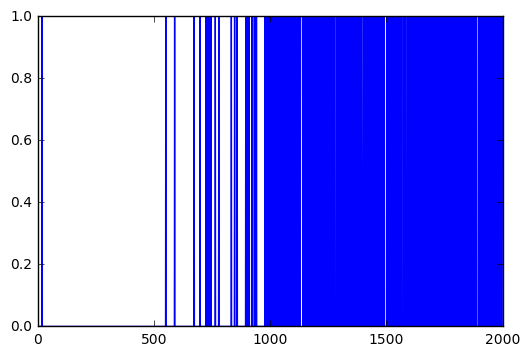

In [9]:
plt.plot(rList)